#***Last-Minute NBA Ticket Sales***
---
Andrea Wright, wrigh282@miamioh.edu




# 1. Introduction <font color='red'> 

## 1.1 Problem Background 

This research explores last-minute ticket sales. "Last minute" is defined as 2 weeks (<15 days) leading up to an event. During this period, a variety of ticket pricing strategies such as dynamic ticket pricing, event-specific deals, etc. can be employed to increase sales. 


## 1.2 Research Goals <font color='red'> 


The goal of this project is to identify key consumer groups that make ticket purchases in the 2 weeks prior to a game and suggest methods of improving sales to these groups. 

## 1.3 Key Assumptions


1. Provided dataset represents the interested population. This meaning that the interested population that is ticket sales leading up to a game is an appropriate and distributive sample. 
2. Assume that we can not determine differences among teams which could potentially sway influence of ticket sales based on other factors. For example, we can not determine if we are looking at a smaller or large market team and must assume each are treated equally in terms of advertising and budgets etc. 
3. The variable TotalSale is the product of AverageTicketPrice and TicketsSold. In other words, a TotalSale = 100 and TicketsSold = 2 results in 2 tickets, each sold at \$50. (I.e. Not one ticket sold at \$60 and the other sold at \$40).


# 2. Project Setup

In [ ]:
# import relevant python packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)

#!pip install kmodes
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 3. Data Manipulation


## 3.1 Data Download
In this section data is downloaded and saved as `all_nba`. We take a brief look at the variables and their data types.

In [ ]:
all_nba = pd.read_csv('NBATicketSales.csv')
all_nba.head()

,Opponent,Season,EventDate,WeekDay,EventTime,SoldDaysBeforeEvent,Level,Position,SectionName,CustomerUniqueID,MethodofDeliveryType,Market,TicketsSold,AverageTicketPrice,TotalSale
0,14.0,2016-2017,2016-12-30,Friday,19:30:00,35.0,LOWER,CORNER,108,8760773.0,WillCall,Primary,0.0,0.0,0.0
1,22.0,2016-2017,2017-01-14,Saturday,19:00:00,87.0,UPPER,CORNER,312,8763320.0,Mobile,Primary,0.0,0.0,0.0
2,7.0,2016-2017,2016-10-27,Thursday,19:30:00,1.0,LOWER,CORNER,113,8770747.0,WillCall,Primary,0.0,0.0,0.0
3,10.0,2016-2017,2017-04-04,Tuesday,19:30:00,32.0,LOWER,CORNER,117,8772521.0,WillCall,Primary,0.0,0.0,0.0
4,4.0,2016-2017,2016-10-14,Friday,19:30:00,57.0,LOWER,CENTER,101,8772615.0,Mobile,Primary,0.0,0.0,0.0


We check the observations for any missing values. 

In [ ]:
all_nba.isna().sum()

Opponent                1
Season                  1
EventDate               1
WeekDay                 1
EventTime               1
SoldDaysBeforeEvent     1
Level                   1
Position                1
SectionName             1
CustomerUniqueID        1
MethodofDeliveryType    1
Market                  1
TicketsSold             1
AverageTicketPrice      1
TotalSale               1
dtype: int64

A single observation appears to be missing. This is removed below. 

In [ ]:
all_nba.dropna(inplace=True)

Next, we evaluate the data type of each variable.

In [ ]:
all_nba.dtypes

Opponent                float64
Season                   object
EventDate                object
WeekDay                  object
EventTime                object
SoldDaysBeforeEvent     float64
Level                    object
Position                 object
SectionName              object
CustomerUniqueID        float64
MethodofDeliveryType     object
Market                   object
TicketsSold             float64
AverageTicketPrice      float64
TotalSale               float64
dtype: object

All data types are appropriate for the analysis. 

## 3.2 Defining the Dataset


### 3.2.1 Isolate ticket sales >0 and >$0

There are instances where the number of tickets sold are 0. Additionally, some tickets are given away for free (denoted as $0) by the organization. We eliminate these to isolate consumers who *purchased* at least one ticket. 

In [ ]:
nba = all_nba[all_nba.TicketsSold > 0]

In [ ]:
nba = nba[nba.AverageTicketPrice > 0]

### 3.2.2 Replace `MethodofDeliveryType` values

The options for `MethodofDeliveryType` contain a range of values. However, we can distinguish these values into two distinct groups: `Mobile` and `NonMobile`. Consumers who opt for `NonMobile` tickets are associated with the original values:

* `WillCall`
* `PrintImmediately`
* `ExternalPDF`
* `StandardShipping`
* `PrintAtHome`

In [ ]:
nba.replace("WillCall", "NonMobile", inplace=True)
nba.replace("PrintImmediately", "NonMobile", inplace=True)
nba.replace("ExternalPDF", "NonMobile", inplace=True)
nba.replace("StandardShipping", "NonMobile", inplace=True)
nba.replace("PrintAtHome", "NonMobile", inplace=True)

### 3.2.3 Isolate "last minute" ticket sales

In [ ]:
nba = nba[nba.SoldDaysBeforeEvent < 15]

## 3.3 Dimension Reduction

### 3.3.1 Initial variable drop

Varaibles are removed as they apply to this reasearch as follows:


*   We are not looking to isolate single games. For that reason, `EventDate` and `EventTime` are removed.
*   We also do not seek to evaluate single customers - `CustomerUniqueID` is removed. 
*   `SectionName` is removed in favor of the more general `Position`.
*   For this reasearch, we are treating the three seasons provided as a single group. For this reason `Season` is removed. 
*  We remove `TotalSale` because it is the product of two existing variables, `TicketsSold` and `AverageTicketPrice`. Additionally, we seek to cluster on a ticket-by-ticket basis rather than evaluate the sale as a whole. 



In [ ]:
nba.drop(columns=['EventDate', 'EventTime', 'CustomerUniqueID', 'SectionName', 'Season', 'TotalSale', 'Opponent'], axis=1, inplace=True)

<ipython-input-10-5e8c6e57534b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba.drop(columns=['EventDate', 'EventTime', 'CustomerUniqueID', 'SectionName', 'Season', 'TotalSale', 'Opponent'], axis=1, inplace=True)


In [ ]:
# validate drop is successful
nba.head()

,WeekDay,SoldDaysBeforeEvent,Level,Position,MethodofDeliveryType,Market,TicketsSold,AverageTicketPrice
202,Thursday,0.0,MIDDLE,CENTER,Mobile,Primary,1.0,61.50
203,Saturday,14.0,MIDDLE,CENTER,Mobile,Primary,1.0,86.25
204,Saturday,0.0,MIDDLE,CENTER,Mobile,Primary,1.0,87.00
205,Wednesday,0.0,LOWER,END,Mobile,Primary,1.0,92.25
209,Saturday,3.0,UPPER,CORNER,NonMobile,Primary,1.0,55.50


# 4. Analytical Techniques

## 4.1 Kmodes Clustering

KModes clustering is a technique similar to that of the more familiar KMeans clustering. Unlike KMeans clustering, KModes is able to evaluate categorical variables. In this dataset, 5/8 variables are categorical. 

In [ ]:
# set up clustering 
cols = nba.columns
K = range(1,7) # this is the number of clusters, K, we will evaluate
cost = [] # instantiate a list to hold the cost, or sum of dissimilarities

In [ ]:
# find best num iterations, append list, "cost"
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=0, random_state=1)
    kmode.fit_predict(nba)
    cost.append(kmode.cost_)

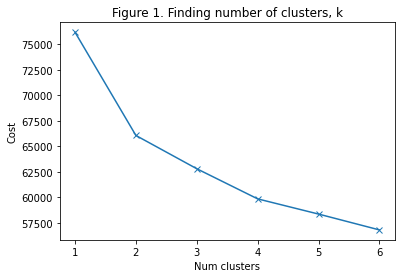

In [ ]:
# plot "cost", shows elbow with best k   
plt.plot(K, cost, 'x-')
plt.xlabel('Num clusters')
plt.ylabel('Cost')
plt.title('Figure 1. Finding number of clusters, k')
plt.show()

Figure 1 above evaluates the cost, or sum of dissimilarities, in the clusters evaluated. Here, we look for the "elbow", which indicates the best number of clusters. The elbow appears at k=2 clusters. We run a model with this number below. 

In [ ]:
# build model with cluster number from above
kmode = KModes(n_clusters=2, init = "random", n_init = 5, verbose=0, )
clusters = kmode.fit_predict(nba)
clusters

array([0, 0, 0, ..., 1, 1, 1], dtype=uint16)

In [ ]:
# show the clusters generated by KModes
centroids = pd.DataFrame(kmode.cluster_centroids_, columns=cols)
centroids

,WeekDay,SoldDaysBeforeEvent,Level,Position,MethodofDeliveryType,Market,TicketsSold,AverageTicketPrice
0,Saturday,0.0,UPPER,CORNER,Mobile,Primary,2.0,30.0
1,Saturday,14.75,LOWER,CENTER,Mobile,Secondary,2.0,50.0


The table above indicates the centroids of the two clusters generated. This is discussed further in *Section 5. Results* and *Section 6. Discussion and Call to Action*

## 4.2 Statistical Analytics

This section is compiled in order to provide comparisons or context to the two consumer groups created in *Section 4.1 KModes Clustering*. Further discussion can be found in *Section 5. Results* and *Section 6. Discussion and Call to Action*. 

In [ ]:
# get df with commonalities for both groups: Saturday, Mobile, 2 Tickets Sold
Saturday_tickets = nba.loc[(nba['WeekDay'] =='Saturday') & (nba['MethodofDeliveryType']=="Mobile") & (nba['TicketsSold']==2)]

In [ ]:
# get average price of tickets from the upper corner, primary market
group_0 = Saturday_tickets.loc[(Saturday_tickets['Level']=="UPPER") & (Saturday_tickets['Position']=="CORNER")&(Saturday_tickets['Market']=="Primary")]
group_0['AverageTicketPrice'].mean()

63.34760705289673

In [ ]:
# average price of tickets for group0 on the day of the event
group_0_new = group_0.loc[(group_0['SoldDaysBeforeEvent']==0)]
group_0_new['AverageTicketPrice'].mean()

54.19117647058823

In [ ]:
# get average price of tickets from the lower center, secondary
group_1 = Saturday_tickets.loc[(Saturday_tickets['Level']=="LOWER") & (Saturday_tickets['Position']=="CENTER")&(Saturday_tickets['Market']=="Secondary")]
group_1['AverageTicketPrice'].mean()

114.47181008902078

In [ ]:
# get average price of tickets from the lower center, primary
group_1_p = Saturday_tickets.loc[(Saturday_tickets['Level']=="LOWER") & (Saturday_tickets['Position']=="CENTER")&(Saturday_tickets['Market']=="Primary")]
group_1_p['AverageTicketPrice'].mean()

178.7982456140351

[Text(0.5, 1.0, 'Figure 2. Cluster Group 1 Average Ticket Price')]

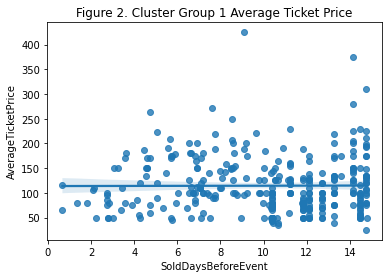

In [ ]:
sns.regplot(x=group_1["SoldDaysBeforeEvent"], y=group_1["AverageTicketPrice"]).set(title='Figure 2. Cluster Group 1 Average Ticket Price')

# 5. Results <font color='orange'> 

Centroids of the clusters generated describe the two consumer groups identified by KModes clustering. **Both groups purchased two tickets for Saturday games and chose mobile delivery.** We can name the groups based on their distinguishing features. 


First, we have the **last-minute bargain hunters**. These customers purchase their tickets the day of an event and choose seats in the upper corner with an average ticket price of $30.

Next, we have the **luxury planners**. These individuals purchase tickets about two weeks prior to a game and choose lower level seats in center court. They pay about $50 per ticket and purchase through a secondary market. 

A detailed description of distinguishing characteristics can be found in *Table 1. Unique cluster attributes*

**Table 1. Unique cluster attributes**

| Cluster|SoldDaysBeforeEvent|Level|Position|Market|AverageTicketPrice [$]|
|--------:|:-----------:|---------|------|:----:|:----:|
|Last-minute bargain hunters|0.00 days|UPPER|CORNER|Primary|30|
|Luxury planners|14.75 days|LOWER|CENTER|Secondary|50|

# 6. Discussion and Call to Action <font color='red'> 

## 6.1 Last-minute bargain hunters

**Cluster Discussion**

In the context of this population, the last-minute bargain hunters truly are "last-minute" since they buy tickets on the day of the event. This group buys tickets in the upper corner and through the primary market. 

In the time frame evaluated for this research, tickets in this section and in this market are sold, on average for \$63. Furthermore, on the day of the event, an average ticket price with these characteristics is \$54. This suggests that this cluster group wants low-priced tickets on short-term notice. 

---

**Cluster Call to Action**

To improve sales for this cluster, it is recommended that the organization implement **dynamic ticket pricing**. In this section specifically, the organization should consider lowering ticket prices, especially in the 2 weeks prior to a game. This suggestion assumes that, since consumers are able to buy tickets at low prices on the day of an event, that this section is not sold out. 

Research may be conducted to determine optimal ticket pricing that strikes a balance between incredibly low prices that risk loss of revenue and overpriced tickets that risk not selling at all. In other words, \$30 per ticket should not be taken as a blanket statement with regards to pricing. 

## 6.2 Luxury planners

**Cluster Discussion**

In the context of this population, this group is considered a planner since they purchase tickets at the end of the time frame evaluated. Further, they are considered luxury planners because they purchase tickets at center court on the lower level, which some may consider the best seats at an NBA game. 

This group purchases tickets on the secondary market, suggesting that these consumers are knowledgeable about the ticket market. Secondary ticket sales can benefit the consumer by increasing price transparency or providing a platform through which the consumer can purchase tickets that are no longer available through the primary vendor (Yilmaz, 2022). It is possible that these consumers evaluate both the primary and secondary markets and that a majority choose the secondary market, but more research is needed to confirm this. 

However, tickets in this section and in the 2 week range are sold, on average, at \$179 by the primary market. In the secondary market, these tickets are sold, on average, at \$114. This is an area for improvement that can be acted upon by the organization. 

---

**Cluster Call to Action**

An understanding that tickets on the secondary market are sold for a lower price than those in the primary market can allow this NBA organization to better strategize ticketing for this consumer group. It is not recommended that the organization lower prices for this section overall - these seats are regarded as valuable and as such, lowering ticket prices would result in decreased revenue and increased demand due to low prices. 

Instead, this organization should consider **ticket bundling**. This group of consumers is not as serious as a season-ticket holder. However, they are consumers who appear to be somewhat interested in planning future events. With this in mind, the organization may consider a ticketing scheme in which consumers can buy tickets for 2 future games in this section. They may bundle highly valuable games (such as those against a tough opponent) with less valuable games (such as those against an easier opponent) at some discounted price that. With this strategy, the organization can rely less on game-by-game ticket sales and dynamic pricing.



# 7. Analysis of Project <font color='red'> 

## 7.1 Strengths

1. Clear idenfitication of groups was determined. Two distinct groups with different purchasing styles were idenfitied in this time frame. 
2. Identification of range. A small range of consumers, those who purchase tickets "last minute" was identified. This range of consumers is more unstable than, for example, season-ticket holders. 
3. Consideration of secondary market. The secondary market is an important factor in modern ticketing. It is important for an organization to understand that the secondary ticket market is a competitor and should be evaluated when implementing dynamic ticket pricing. 


## 7.2 Weaknesses

1. The variable event time could have provided info such as timing of games and how much they sell. For example, we may expect consumers of a 7pm game to be different than those of a 12pm game. 

2. To improve the specificity of this analysis, a single section or level could have been selected for improvement.

3. Removal of opponent is a factor that should be considered. Games against highly competitive teams are more likely to sell greater number of tickets than those against less competitive opponents. 

4. Evaluation on a ticket-by-ticket basis eliminates large group sales that may have occurred in the "last-minute" time frame, although unlikely. 

# 8. Appendix

## 8.1 Sources

Yilmaz, Ovunc and Easley, Robert F. and Ferguson, Mark, The Future of Sports Ticketing: Technologies, Data, and New Strategies (October 27, 2022). Available at SSRN: https://ssrn.com/abstract=4260366 or http://dx.doi.org/10.2139/ssrn.4260366